# Quick Start Guide
This tutorial shows how to quickly get started using scarlet to reduce a sample image cube.
In order to run this tutorial you will need either `astropy` (http://www.astropy.org) or `sep` (https://github.com/kbarbary/sep) installed to open/create the source catalog and `matplotlib` (https://matplotlib.org) to display the images

In [1]:
# Import Packages and setup
import logging

import numpy as np

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

## Load and display the sample data

### Load the sample data and source catalog

In [2]:
# Load the sample images
data = np.load("../data/hsc_cosmos_35.npz")
images = data["images"]
filters = data["filters"]
psfs = data["psfs"]
catalog = data["catalog"]
bg_rms = np.ones((len(psfs),), dtype=images.dtype) * .1

### Display a raw image cube
This is an example of how to display an RGB image from an image cube of multiband data. In this case the image uses a $sin^{-1}$ function to normalize the flux and maps i,r,g (filters 3,2,1) $\rightarrow$ RGB.

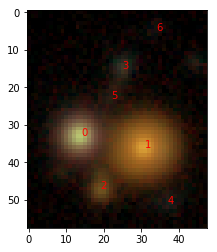

In [3]:
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping

stretch = 1
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)

x = np.fft.rfftn(images[0], [90,90])
print(x.shape, images.shape)

# Mark all of the sources from the detection cataog
for k, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(k), color="red")

## Create a target PSF

While it is possible to estimate a target PSF, we just choose
a minimal PSF that is barely well sampled and use it as our
target kernel.

In [4]:
X = np.arange(psfs.shape[2])
Y = np.arange(psfs.shape[1])
X, Y = np.meshgrid(X, Y)
coords = np.stack([Y, X])
y0, x0 = (psfs.shape[1]-1) // 2, (psfs.shape[2]-1) // 2
target_psf = scarlet.psf.gaussian(coords, y0, x0, 1, .9)
target_psf /= target_psf.sum()

## Initialize the observation and the model

A `Scene` in scarlet is the scene that the model lives in, including information about the number of bands, size of the image in Y and X, (optional) WCS info to translate from pixel to sky coordinates, and (optionally) a filter curve used to map from the model filter bands to a more continuous spectrum (not yet supported).

Each `Observation` corresponds to a a set of observed data, which contains a data cube with an image in each filter, a list of filter names, and (optionally) WCS info to translate from pixel coordinates to sky coordinates. It also internally matches the PSF in each filter to the target PSF of the scene once a blend is initialized.

In [5]:
observations = scarlet.Observation(images, psfs)
scene = scarlet.Scene(images.shape, psfs=target_psf)

## Initialize the sources
Each source is a list of fundamental `scarlet.Component` instances and must be based on `scarlet.Source` or a derived class, in this case `ExtendedSource`, which initializes a source as monotonic and symmetric (for those familiar with the SDSS/HSC deblender, the initialized model is essentially the SDSS/HSC model template).

Occasionally a source might not have flux in any band above the noise threshold, which means that it cannot be initialzed and will return a `SourceInitError`. The code below shows one way of handling sources with low/no flux, although it is up to users to implement their own strategies based on their science needs.

In [6]:
sources = []
for src in catalog:
    try:
        new_source = scarlet.ExtendedSource((src['y'], src['x']), scene, observations, bg_rms)
    except scarlet.SourceInitError:
        try:
            new_source = scarlet.PointSource((src['y'], src['x']), scene, observations)
        except scarlet.SourceInitError:
            print("Could not initialze source at {0}".format((src['y'], src['x'])))
            continue
    sources.append(new_source)

## Create and fit the model
The `scarlet.Blend` class represent the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

In [7]:
blend = scarlet.Blend(scene, sources, observations)
blend.fit(200, e_rel=1e-3)
print("scarlet ran for {0} iterations".format(blend.it))

[90, 90] (5, 43, 43) (5, 90, 46) zizi


/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/fft.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return anp.pad(x, pads, 'constant')[slices]


scarlet ran for 200 iterations


## View the results

### View the full model
First we load the model for the entire blend and its residual. Then we display the model using the same $sinh^{-1}$ stretch as the full image and a linear stretch for the residual.

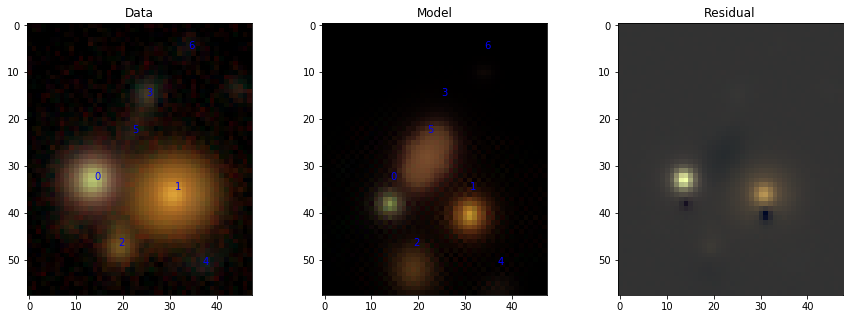

In [8]:
# Load the model and calculate the residual
_model = blend.get_model()
model = observations.get_model(_model)
residual = images-model
# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend.components):
    y,x = component.pixel_center
    ax[0].text(x, y, k, color="b")
    ax[1].text(x, y, k, color="b")
plt.show()

### View the source models
It can also be useful to view the model for each source. For each source we extract the portion of the image contained in the sources bounding box, the true simulated source flux, and the model of the source, scaled so that all of the images have roughly the same pixel scale.

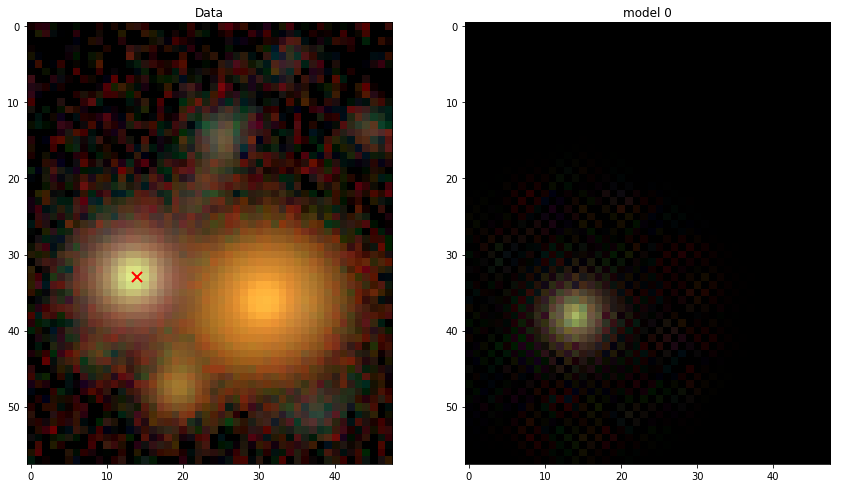

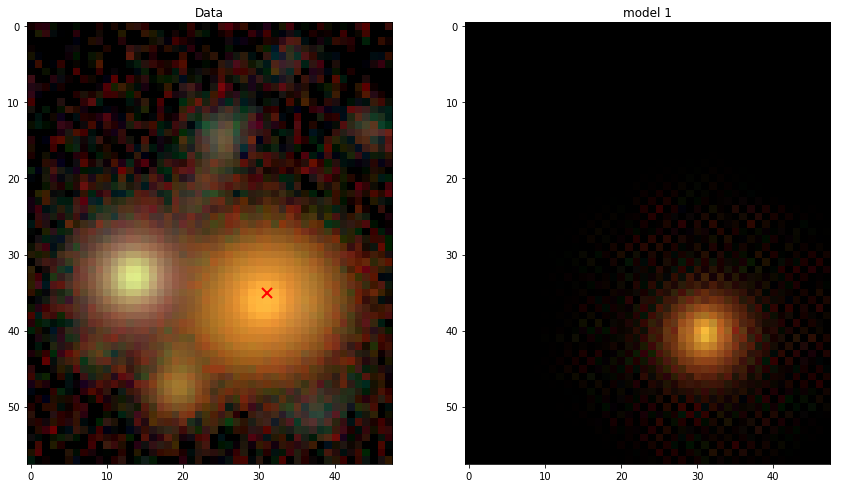

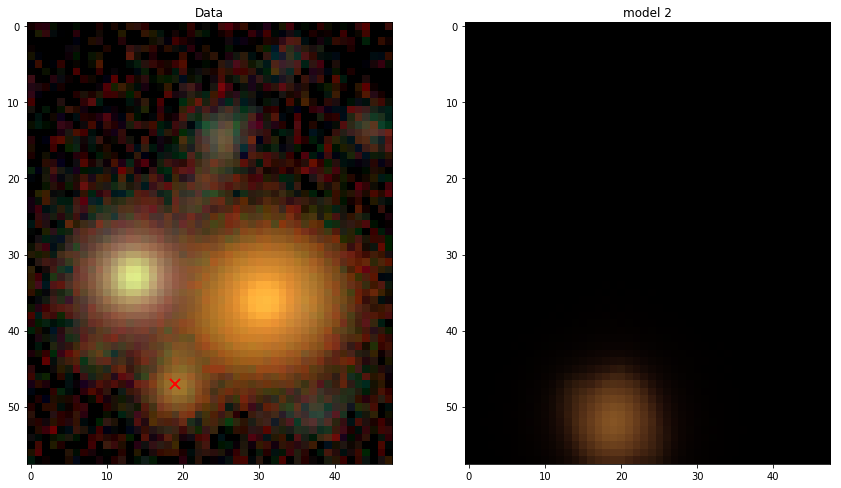

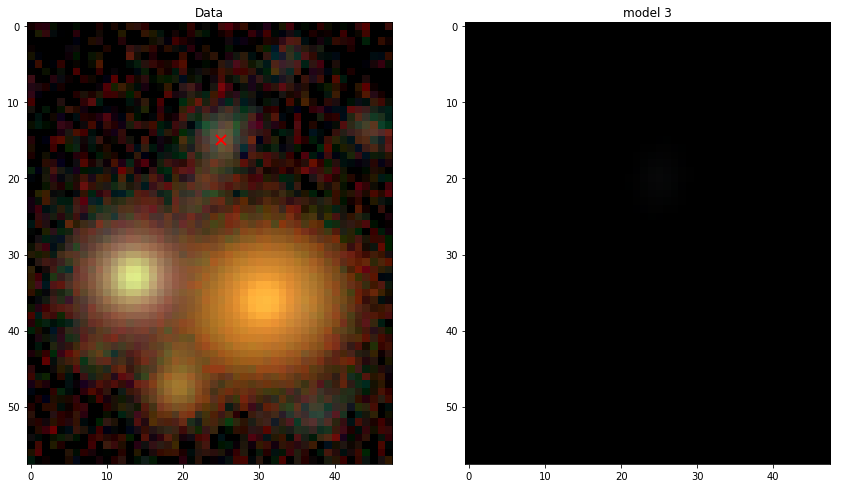

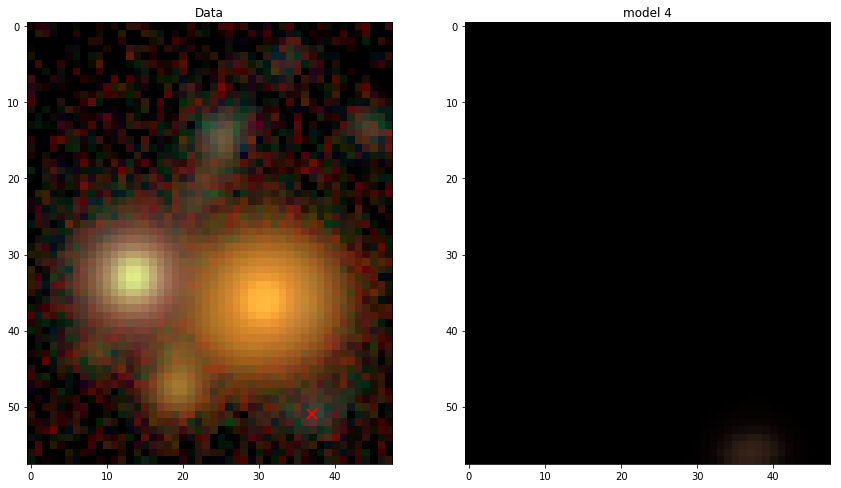

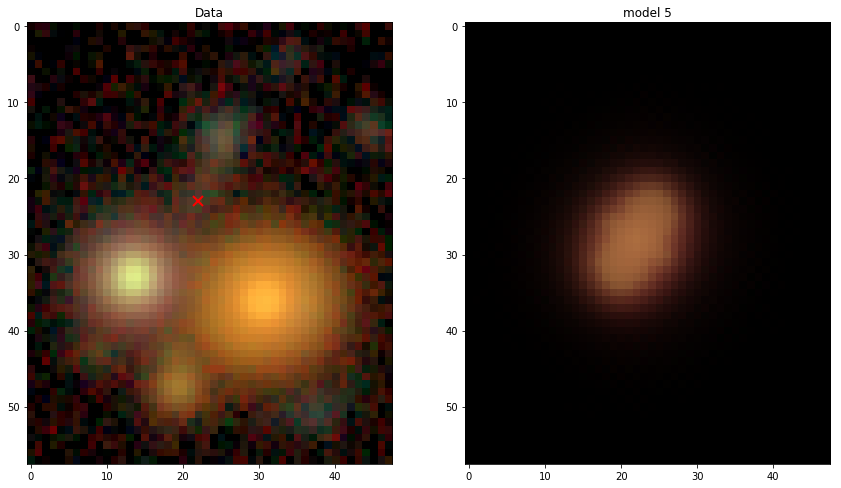

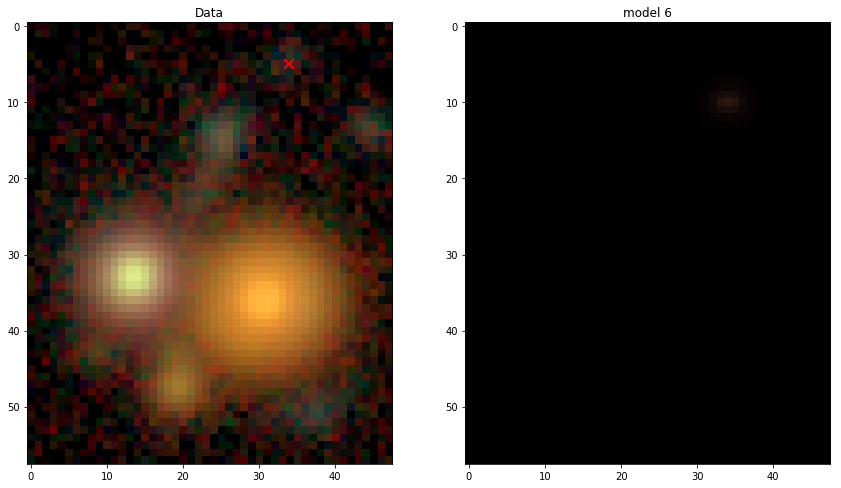

In [17]:
def get_true_image(m, catalog, filters):
    """Create the true multiband image for a source
    """
    img = np.array([np.sum(catalog[catalog["index"]==m]["intensity_"+f], axis=0) for f in filters])
    return img

# We can only show the true values if the input catalog has the true intensity data for the sources
# in other words, if you used SEP to build your catalog you do not have the true data.
if "intensity_"+filters[0] in catalog.dtype.names:
    has_truth = True
    axes = 3
else:
    has_truth = False
    axes = 2

# Set the stretch based on the model
stretch = .3
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

for k,src in enumerate(blend.components):
    # Get the model for a single source
    _model = src.get_model()
    model = observations.get_model(_model)
    model_rgb = scarlet.display.img_to_rgb(model, norm=norm)
    # Get the patch from the original image
    img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
    # Set the figure size
    ratio = src.shape[2]/src.shape[1]
    fig_height = 3*src.shape[1]/20
    fig_width = max(2*fig_height*ratio,2)
    fig = plt.figure(figsize=(fig_width, fig_height))
    # Generate and show the figure
    ax = [fig.add_subplot(1,2,n+1) for n in range(2)]
    ax[0].imshow(img_rgb)
    ax[0].set_title("Data")
    ax[1].imshow(model_rgb)
    ax[1].set_title("model {0}".format(k))
    # Mark the source in the data image
    ax[0].plot(src.pixel_center[1], src.pixel_center[0], "rx", mew=2, ms=10)
    plt.show()